# Simple demo of semi-NMF on synthetic data

The model is described here: https://www.overleaf.com/project/649e4d41313d17d01bde7cfb


## Notes
- Unsurprisingly, initialization is important for this coordinate ascent algorithm. We used a simple heuristic of initializing with the SVD, flipping signs and rescaling the singular vectors to fit the model requirements. It seems to work well for this example, but we'll see how it does on real data.

- I rewrote the proximal updates with jax `while_loop` and `scan` primitives. It's much faster now!

- I added support for variable number of cells (`counts`) per voxel, with `counts == 0` effectively serving as missing data. This required some small changes to the initialization code: first I impute the missing data with a simple low-rank reconstruction via SVD, then I pass the imputed data into an NNSVD to initialize the semiNMF factors.

## Next steps
- Disentangle the upsampling likelihood from the semiNMF model. We should be able to run semiNMF on the downsampled and flattened data just as well. 
- Test on realistic-sized 3D data ($\approx$ brain volumes) using Sherlock

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cfos import seminmf
from tensorflow_probability.substrates import jax as tfp
from jax.image import resize
tfd = tfp.distributions

## Make synthetic 2D dataset for testing

In [2]:
key = jr.PRNGKey(1)
num_mice = 20
height, width = 100, 100
downsample_factor = 4
num_factors = 3
emission_noise_scale = 1.0
loading_scale = 10.0

# Make some simple factors
xx, yy = jnp.meshgrid(jnp.arange(width // downsample_factor), jnp.arange(height // downsample_factor))
true_weights = jnp.zeros((num_factors, height // downsample_factor, width // downsample_factor))
true_weights = true_weights.at[0].set(jnp.where((xx >= 2) & (xx < 5) & (yy >= 5) & (yy < 8), 1.0, 0.0))
true_weights = true_weights.at[1].set(jnp.where((xx >= 15) & (xx < 19) & (yy >= 7) & (yy < 12), 1.0, 0.0))
true_weights = true_weights.at[2].set(jnp.where(((xx - 10)**2 + (yy - 20)**2) <= 4**2, 1.0, 0.0))
true_weights /= true_weights.sum(axis=(1, 2), keepdims=True)

# Sample data
k1, k2, k3 = jr.split(key, 3)

# Sample factors
true_loadings = tfd.Laplace(0.0, loading_scale).sample(seed=k1, sample_shape=(num_mice, num_factors))

# Sample data
counts = 0.0 + jr.poisson(k3, 3.0, (num_mice, height, width))

# Zero out a block
counts = counts.at[0, 20:30, 20:30].set(0)

# counts = jnp.ones((num_mice, height, width))
mus = jnp.einsum('mk, khw->mhw', true_loadings, resize(true_weights, (num_factors, height, width), method="linear"))
data = tfd.Normal(mus, jnp.sqrt(emission_noise_scale**2 / counts)).sample(seed=k2)
data = jnp.where(jnp.isfinite(data), data, 0.0)

## Plot factors and a few data points

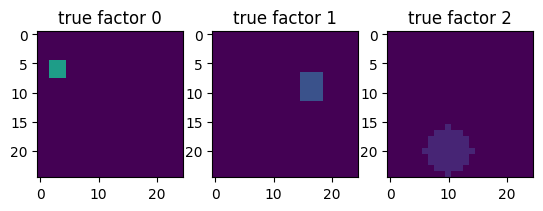

In [3]:
# Plot the factors
fig, axs = plt.subplots(1, num_factors)
for k in range(num_factors):
    axs[k].imshow(true_weights[k], vmax=0.2)
    axs[k].set_title("true factor {}".format(k))

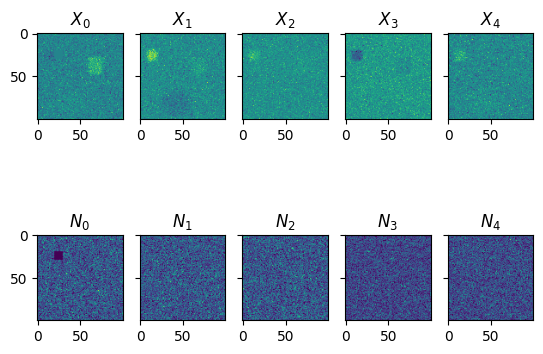

In [4]:
# Plot some of the data
fig, axs = plt.subplots(2, 5, sharey=True)
for m in jnp.arange(5):
    axs[0, m].imshow(data[m])
    axs[0, m].set_title(r"$X_{}$".format(m))
    axs[1, m].imshow(counts[m])
    axs[1, m].set_title(r"$N_{}$".format(m))

## Fit the model!

In [6]:
# Fit the model
losses, loadings, weights = \
    seminmf.fit_batch(data, 
                      counts,
                      num_factors,
                      emission_noise_scale=emission_noise_scale,
                      loading_scale=loading_scale,
                      num_iters=5,
                      verbosity=0,
                      key=1,
                      initialization="nnsvd")

Imputing missing data based on a rank 20 SVD


  0%|          | 0/10 [00:00<?, ?it/s]

done
initial loss:  0.9182335


  0%|          | 0/5 [00:00<?, ?it/s]

Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.9133565
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.91325223
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.9132084
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.91318095
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.9131622


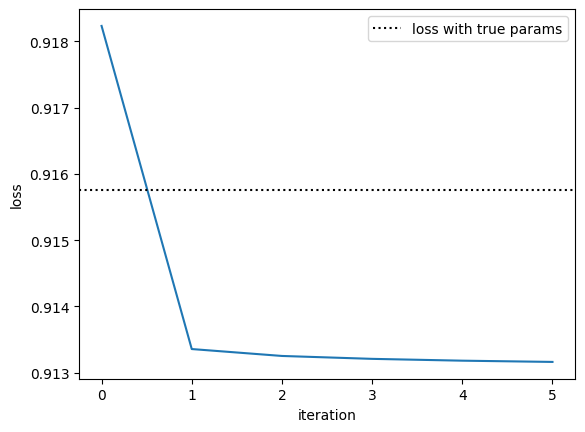

In [7]:
# Plot the losses
plt.figure()
plt.plot(losses)
plt.axhline(seminmf.compute_loss(data, counts, true_loadings, true_weights, emission_noise_scale),
            ls=':', color='k', label='loss with true params')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

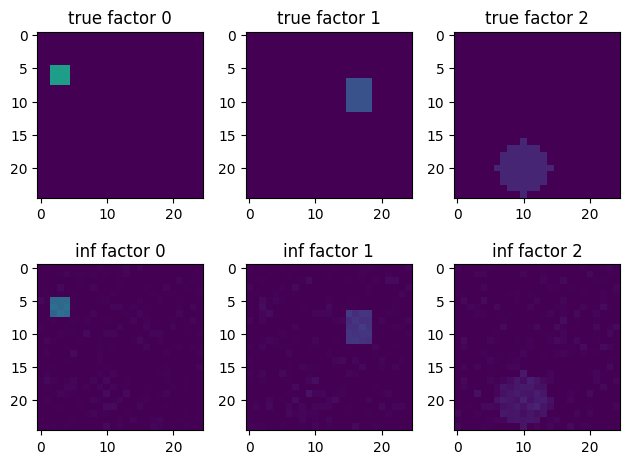

In [8]:
# Plot the factors
fig, axs = plt.subplots(2, num_factors)
for k in range(num_factors):
    axs[0, k].imshow(true_weights[k], vmax=0.2)
    axs[0, k].set_title("true factor {}".format(k))

    axs[1, k].imshow(weights[k], vmax=0.2)
    axs[1, k].set_title("inf factor {}".format(k))
plt.tight_layout()

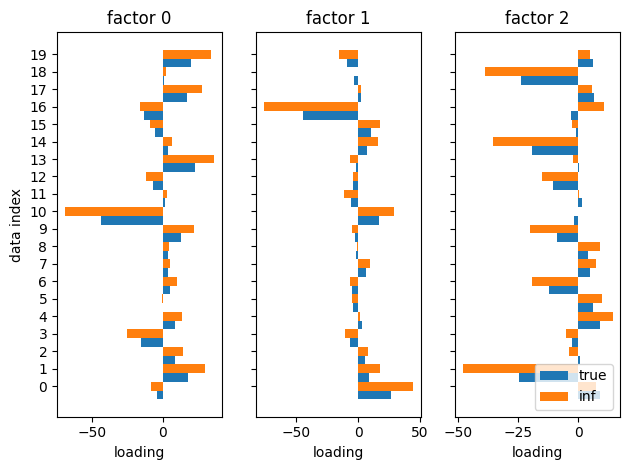

In [9]:
# Plot the loadings
fig, axs = plt.subplots(1, num_factors, sharey=True)
for k in range(num_factors):
    axs[k].barh(jnp.arange(num_mice), true_loadings[:, k], height=0.5, label='true')
    axs[k].barh(jnp.arange(num_mice)+.5, loadings[:, k], height=0.5, label='inf')
    axs[k].set_title("factor {}".format(k))
    axs[k].set_yticks(jnp.arange(num_mice) + .5)
    axs[k].set_yticklabels(jnp.arange(num_mice))
    axs[k].set_xlabel("loading")
    
    if k == 0:
        axs[k].set_ylabel("data index")
        
    if k == num_factors - 1:
        axs[k].legend(loc="lower right")

        plt.tight_layout()

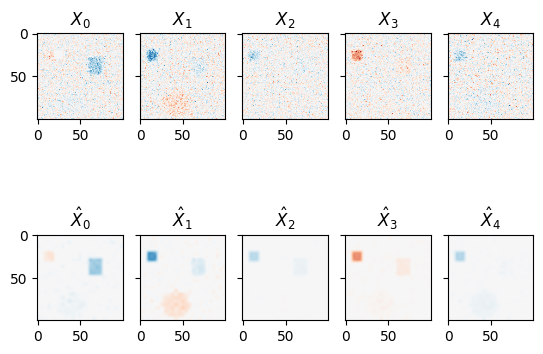

In [10]:
# Plot data and reconstructions
fig, axs = plt.subplots(2, 5, sharey=True)
reconstruction = seminmf.compute_mean(data, loadings, weights)
for m in range(5):
    vmax = abs(data[m]).max()
    axs[0, m].imshow(data[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[0, m].set_title(r"$X_{}$".format(m))
    
    axs[1, m].imshow(reconstruction[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[1, m].set_title(r"$\hat{{X}}_{}$".format(m))

## Conclusion

It's working for this super simple example! 
